In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
from datetime import datetime, timedelta
import sys

from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D

plt.style.use("~/evanstyle.mplstyle")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'

#import the folder that has the analysis level class
sys.path.append("../CombinedData/")
sys.path.append("../AnalysisTools/")
import Dataset
import AnalysisTools

In [2]:
toproot = "/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/"
#toproot = "../../data/"
topdirs = {5:toproot+"Run5/", 6:toproot+"Run6/", 7:toproot+"Run7/", 8:toproot+"Run8/", 9:toproot+"Run9/", 10:toproot+"Run10/"}
configs = {5:"../configs/run5_config.yaml", 6:"../configs/run6_config.yaml", 7:"../configs/run7_config.yaml", 8:"../configs/run8_config.yaml", 9:"../configs/run9_config.yaml", 10:"../configs/run10_config.yaml"}
titles = {5:"SS uncoated", 6:"Refill of SS uncoated", 7:"MgF2 (50nm)", 8:"Pt (50nm)", 9:"MgF2 (20nm)", 10:"SS304"}
red_file_name = "combined_reduced.p"
#analysis tools objects, unloaded data
anas = {}
for n in topdirs:
    if(n == 6 or n == 5):continue
    anas[n] = AnalysisTools.AnalysisTools(topdirs[n]+red_file_name, configs[n], title=titles[n], ramp_topdir=topdirs[n])


/g/g91/si2/HV/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:137: UserWarning: genfromtxt: Empty input file: "/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/Run8/ds03/g_events.txt"
  d = np.genfromtxt(os.path.join(root, self.config["g_events_name"]), delimiter=',', dtype=float)


In [3]:
#load data into mem if you want
for n, ana in anas.items():
    if(n == 6 or n ==5): continue
    ana.load_dataframe()

In [19]:
ana = anas[8]
df7 = ana.df
#df7 = df7[~df7["ch3 charge"].isna()]

In [20]:
from scipy.stats import poisson

# Calculate the minimum time (in seconds) for normalization
min_t_sec = np.min(df7["ch0 seconds"])
df7.loc[:, "ch0 tzerod"] = (df7["ch0 seconds"] - min_t_sec) + df7["ch0 nanoseconds"] / 1e9

df7 = df7.sort_values(by="ch0 tzerod")

# Calculate the absolute time
df7.loc[:, "abs_time"] = df7["ch0 seconds"] + df7["ch0 nanoseconds"] / 1e9


# Calculate the number of events in each 10-second interval
dur = 10 # seconds
start_time = df7["abs_time"].min()
end_time = df7["abs_time"].max()
bins = np.arange(start_time, end_time + dur, dur)

# Calculate the 99.9% confidence interval using Poisson distribution
lambda_value = 8.8
confidence_level = 0.999
interval = poisson.interval(confidence_level, lambda_value)
upper_limit = interval[1]
down_limit = interval[0]

df7['interval'] = pd.cut(df7["abs_time"], bins, right=False)

# Calculate the number of events in each interval
event_counts = df7.groupby('interval', observed=False).size()

# Find the start times of intervals where event count exceeds the upper limit
exceed_intervals = event_counts[event_counts > upper_limit].index

# Extract the left edge (start times) of these intervals
exceed_times = [(interval.left, event_counts[interval])for interval in exceed_intervals]

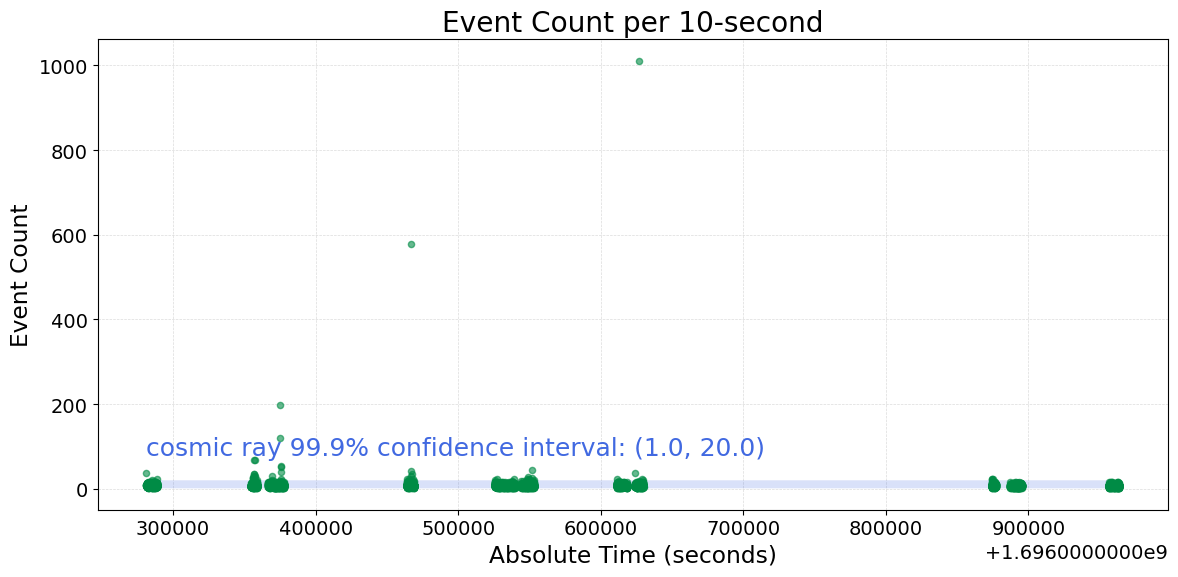

Times with event count exceeding upper limit: [(1696281344.914, 37), (1696288774.914, 24), (1696356244.914, 28), (1696356264.914, 25), (1696356284.914, 24), (1696356294.914, 26), (1696356534.914, 29), (1696356604.914, 21), (1696356614.914, 34), (1696356644.914, 35), (1696356654.914, 68), (1696357144.914, 28), (1696357154.914, 69), (1696357784.914, 31), (1696359134.914, 21), (1696369554.914, 30), (1696375214.914, 199), (1696375224.914, 119), (1696375414.914, 24), (1696375424.914, 40), (1696375434.914, 53), (1696375444.914, 52), (1696464314.914, 24), (1696465624.914, 23), (1696467174.914, 578), (1696467234.914, 29), (1696467244.914, 43), (1696467424.914, 35), (1696468114.914, 23), (1696526084.914, 21), (1696527564.914, 22), (1696538794.914, 23), (1696548174.914, 22), (1696548944.914, 27), (1696549624.914, 23), (1696550294.914, 21), (1696551694.914, 25), (1696551704.914, 44), (1696611144.914, 23), (1696624134.914, 38), (1696626754.914, 1011), (1696628704.914, 22), (1696629444.914, 21), (1

In [21]:
# Remove intervals with zero events
filtered_intervals = event_counts[event_counts != 0].index.categories.left.values[event_counts[event_counts != 0].index.codes]
filtered_nev = event_counts[event_counts != 0].values

# Plot the event count over time
plt.figure(figsize=(12, 6))

# Fill the area between the confidence interval limits
plt.fill_between(filtered_intervals, down_limit, upper_limit, color='#4169E1', alpha=0.2,edgecolor='none')

# Plot the event counts
plt.scatter(filtered_intervals, filtered_nev, marker='o', s=20, c='#008B45', alpha=0.6)

# Add annotation with confidence interval information
plt.text(start_time, 80, f'cosmic ray {confidence_level * 100}% confidence interval: {interval}', fontsize=18, color='#4169E1')

# Set labels and title
plt.xlabel('Absolute Time (seconds)')
plt.ylabel('Event Count')
plt.title('Event Count per 10-second')
plt.grid(True, linestyle= '--', alpha=0.7)
plt.tight_layout()
#plt.ylim([0, 40])
plt.show()

# Print the times with event count exceeding the upper limit
print("Times with event count exceeding upper limit:", exceed_times)

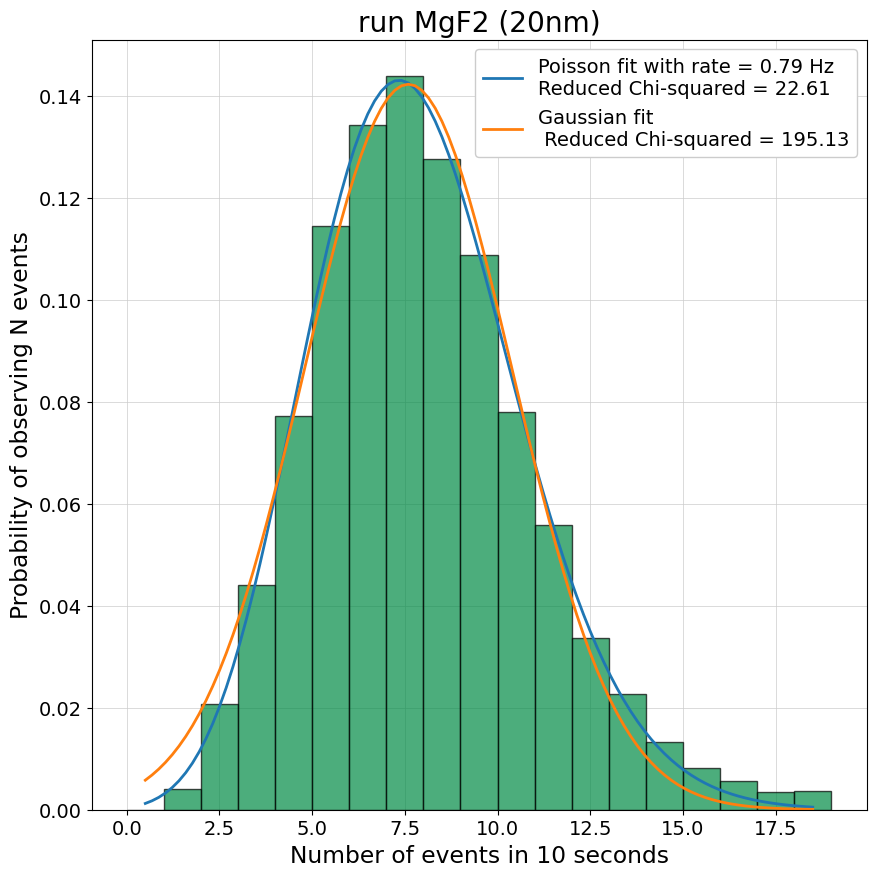

In [30]:
from datetime import datetime
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.special import loggamma

# Fit and plot histogram of event counts
def fitfunc(k, lam):
    return np.exp(k * np.log(lam) - lam - loggamma(k + 1))

fig, ax = plt.subplots()

bins = range(int(2 * dur))  # number of events in dur seconds
n, bins, patches = ax.hist(filtered_nev, bins=bins, density=True, alpha=0.7, color='#008B45', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Function for fitting Gaussian
def gaussian_fit(k, mu, sigma):
    return norm.pdf(k, loc=mu, scale=sigma)

# Fit Gaussian distribution to the original data
gaussian_popt, _ = curve_fit(lambda x, mu, sigma: gaussian_fit(x, mu, sigma), bin_centers, n, p0=[np.mean(filtered_nev), np.std(filtered_nev)])

# Fit Poisson distribution to the original data
popt, pcov = curve_fit(fitfunc, bin_centers, n, p0=[np.mean(filtered_nev)])

fitx = np.linspace(np.min(bin_centers), np.max(bin_centers), 100)
fity = fitfunc(fitx, *popt)
red_x2 = 0 
ndf = len(bin_centers) - 1
for i in range(len(n)):
    fitval = fitfunc(bin_centers[i], *popt)
    red_x2 += len(filtered_nev) * (n[i] - fitval) ** 2 / fitval / ndf

# Recreate the Gaussian distribution fit
gaussian_fitx = np.linspace(np.min(bin_centers), np.max(bin_centers), 100)
gaussian_fity = gaussian_fit(gaussian_fitx, gaussian_popt[0], gaussian_popt[1])

# Calculate reduced chi-squared for Gaussian
red_x2_gaussian = 0
for i in range(len(n)):
    fitval = gaussian_fit(bin_centers[i], gaussian_popt[0], gaussian_popt[1])
    red_x2_gaussian += len(filtered_nev) * (n[i] - fitval) ** 2 / fitval / ndf

# Plot the fits
ax.plot(fitx, fity, label=f"Poisson fit with rate = {popt[0] / dur:.2f} Hz\nReduced Chi-squared = {red_x2:.2f}")
ax.plot(gaussian_fitx, gaussian_fity, label=f"Gaussian fit\n Reduced Chi-squared = {red_x2_gaussian:.2f}")

ax.set_title("run {}".format(ana.title))
ax.set_xlabel("Number of events in {:0.0f} seconds".format(dur))
ax.set_ylabel("Probability of observing N events")
ax.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.colors as mcolors

# Load and process data
ana.load_hv_textfiles()
ana.correct_hv_data()  # Analyzes the ramp data to separate into a list of ramps and a list of flat tops
ana.create_time_duration_map()

# Filter data
df7_filtered = df7.dropna(subset=["ch3 charge"])
mask = np.abs(df7_filtered["ch3 charge"]) > 0.1
df7_charge_events = df7_filtered[mask].copy()
df7_charge_events["ch3 abs_time"] = df7_charge_events["ch3 seconds"] + df7_charge_events["ch3 nanoseconds"] / 1e9

# Define sampling times based on channel (in microseconds)
dT = {0: 1.0/125, 1: 1.0/125, 3: 0.5, 4: 1.0/125}

# Plot the event count over time for each exceed time
for start, count in exceed_times:
    # Define the time window
    time_window_start = start -5
    time_window_end = start + 25

    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[1, 2], hspace=0.05)

    ax_top = fig.add_subplot(gs[0])
    ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)
    
    time_bounds = [time_window_start, time_window_end]

    # Plot high voltage on the top subplot
    tempbins = np.arange(time_window_start, time_window_end, 0.1)
    hvs = [ana.get_hv_at_time(_) for _ in tempbins]

    # Normalize tempbins to start from 0
    tempbins_normalized = tempbins - time_window_start

    # Plot HV data
    ax_top.plot(tempbins_normalized, hvs, 'ko-')

    # Plot gevents on this HV plot as well
    gdf = ana.get_gevents_in_window(time_window_start, time_window_end)
    gdf = gdf.copy()  # Make a copy to avoid SettingWithCopyWarning
    gdf["normalized_time"] = gdf["t"] - time_window_start
    ax_top.scatter(gdf["normalized_time"], gdf["v_app"], color="red", s=100)

    ax_top.set_ylabel("HV applied [kV]")
    ax_top.set_title(f"Reference start time: {datetime.fromtimestamp(time_window_start)}, Event count: {count}")

    # Plot charge data on the bottom subplot
    mask = (df7_charge_events["ch3 abs_time"] >= time_window_start) & (df7_charge_events["ch3 abs_time"] <= time_window_end)
    df7_charge_events_time = df7_charge_events[mask].copy()

    # Use np.nan_to_num to deal with infinity
    df7_charge_events_time["ch3 charge"] = np.nan_to_num(np.abs(df7_charge_events_time["ch3 charge"]), nan=np.nan, posinf=np.nan, neginf=np.nan)
    max_charge = df7_charge_events_time["ch3 charge"].dropna().max()

    ax_bottom.scatter(df7_charge_events_time["ch3 abs_time"] - time_window_start, np.abs(df7_charge_events_time["ch3 charge"]), color="#1E90FF", s=100, label="charge events")

    # Plot light channel data on the bottom subplot (ch0)
    mask_ch0 = (df7["ch0 seconds"] + df7["ch0 nanoseconds"] / 1e9 >= time_bounds[0]) & (df7["ch0 seconds"] + df7["ch0 nanoseconds"] / 1e9 <= time_bounds[1])
    df7_ch0_events = df7[mask_ch0].copy()
    df7_ch0_events["ch0 abs_time"] = df7_ch0_events["ch0 seconds"] + df7["ch0 nanoseconds"] / 1e9
    df7_ch0_events = df7_ch0_events.sort_values(by="ch0 abs_time")
    df7_ch0_events["ch0 signal"] = df7_ch0_events["ch0 amp"] - df7_ch0_events["ch0 baseline"]

    # Plot light channel data on the bottom subplot (ch1)
    mask_ch1 = (df7["ch1 seconds"] + df7["ch1 nanoseconds"] / 1e9 >= time_bounds[0]) & (df7["ch1 seconds"] + df7["ch1 nanoseconds"] / 1e9 <= time_bounds[1])
    df7_ch1_events = df7[mask_ch1].copy()
    df7_ch1_events["ch1 abs_time"] = df7_ch1_events["ch1 seconds"] + df7["ch1 nanoseconds"] / 1e9
    df7_ch1_events = df7_ch1_events.sort_values(by="ch1 abs_time")
    df7_ch1_events["ch1 signal"] = df7_ch1_events["ch1 amp"] - df7_ch1_events["ch1 baseline"]

    # Scatter plot for ch0 and ch1 signal with transparency
    ax2 = ax_bottom.twinx()
    ax2.scatter(df7_ch0_events["ch0 abs_time"] - time_window_start, df7_ch0_events["ch0 signal"], color="green", s=30, alpha=0.3, label="ch0 signal (mV)")
    ax2.scatter(df7_ch1_events["ch1 abs_time"] - time_window_start, df7_ch1_events["ch1 signal"], color="orange", s=30, alpha=0.3, label="ch1 signal (mV)")

    # Set y-axis limits based on the maximum value of ch0 and ch1 signals
    max_signal = max(df7_ch0_events["ch0 signal"].max(), df7_ch1_events["ch1 signal"].max())
    if pd.notna(max_signal):
        ax2.set_ylim([0, max_signal * 1.2])

    # Set left y-axis to blue
    ax_bottom.spines['left'].set_color('#1E90FF')
    ax_bottom.yaxis.label.set_color('#1E90FF')
    ax_bottom.tick_params(axis='y', colors='#1E90FF')
    ax_bottom.set_ylabel("Charge injected [pC]")

    # Set right y-axis label
    ax2.set_ylabel("PMT amp [mV]")

    # Customize grid for the bottom subplot
    ax_bottom.grid(False)

    ax_bottom.legend(loc="upper left", framealpha = 0.5)
    ax2.legend(loc="upper right", framealpha = 0.5)

    # Remove x-axis labels from the top subplot
    plt.setp(ax_top.get_xticklabels(), visible=False)

    plt.show()

    
   # Create a custom colormap with white for zero counts
    cmap = plt.cm.viridis
    cmap.set_under(color='white')

   # Find and plot (ch0 - ch1) / (ch0 + ch1) signal
    fig, (ax_asymmetry, ax_asymmetry_dist) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.0001})
    merged_df = pd.merge(df7_ch0_events, df7_ch1_events, left_on="ch0 abs_time", right_on="ch1 abs_time", suffixes=('_ch0', '_ch1'))
    merged_df["ratio_signal"] = (merged_df["ch0 signal"] - merged_df["ch1 signal"]) / (merged_df["ch0 signal"] + merged_df["ch1 signal"])

    # Define the bins for x and y axes
    x_bins = np.linspace(merged_df["ch0 abs_time"].min() - time_window_start, merged_df["ch0 abs_time"].max() - time_window_start, 130)
    y_bins = np.linspace(merged_df["ratio_signal"].min(), merged_df["ratio_signal"].max(), 30)

    # Plot the 2D histogram for asymmetry
    h = ax_asymmetry.hist2d(merged_df["ch0 abs_time"] - time_window_start, merged_df["ratio_signal"], bins=(x_bins, y_bins), cmap=cmap, norm=mcolors.Normalize(vmin=0.1))
    ax_asymmetry.set_ylabel("ch0 ch1 Asymmetry")
    ax_asymmetry.set_xlabel("Time [s]")
    ax_asymmetry.grid(True)

    # Add a colorbar to show the count in each bin
    plt.colorbar(h[3], ax=ax_asymmetry, label='Counts')

    # Plot the histogram
    ax_asymmetry_dist.hist(merged_df["ratio_signal"], bins=30, color='#7B68EE', alpha=0.7, orientation='horizontal')
    ax_asymmetry_dist.axhline(0, color='black', linestyle='--')
    ax_asymmetry_dist.grid(True)
    ax_asymmetry_dist.set_xlabel("Count")
    ax_asymmetry_dist.tick_params(left=False, labelleft=False)

    plt.show()
    
    # Sampling time in nanoseconds for the overlay plots
    dT_ns = 1000.0 / 125  # ns
    
    # Plot overlay of all ch0 waveforms
    events_ch0 = ana.get_waveforms_from_df(df7_ch0_events, [0])
    fig, ax_ch0 = plt.subplots(figsize=(10, 6))
    for e in events_ch0[0]:
        times = np.arange(0, len(e["Data"]) * dT_ns, dT_ns)
        ax_ch0.plot(times, e["Data"], color='green', linewidth=0.5, alpha=0.3)
    ax_ch0.set_xlim([0, 1000])
    ax_ch0.set_xlabel("time [ns]")
    ax_ch0.set_ylabel("amplitude [mV]")
    ax_ch0.set_title("Overlay of all ch0 waveforms")
    plt.show()

    # Plot overlay of all ch1 waveforms
    events_ch1 = ana.get_waveforms_from_df(df7_ch1_events, [1])
    fig, ax_ch1 = plt.subplots(figsize=(10, 6))
    for e in events_ch1[1]:
        times = np.arange(0, len(e["Data"]) * dT_ns, dT_ns)
        ax_ch1.plot(times, e["Data"], color='orange', linewidth=0.5, alpha=0.3)
    ax_ch1.set_xlim([0, 1000])
    ax_ch1.set_xlabel("time [ns]")
    ax_ch1.set_ylabel("amplitude [mV]")
    ax_ch1.set_title("Overlay of all ch1 waveforms")
    plt.show()

    # Sampling time in microseconds for ch3
    dT_ch3 = 1.0  # µs
    
    # Plot overlay of all ch3 waveforms
    events_ch3 = ana.get_waveforms_from_df(df7_charge_events_time, [3])
    fig, ax_ch3 = plt.subplots(figsize=(10, 6))
    for e in events_ch3[3]:
        times = np.arange(0, len(e["Data"]) * dT_ch3, dT_ch3)
        ax_ch3.plot(times, e["Data"], color='#1E90FF', linewidth=0.5, alpha=0.8)
    ax_ch3.set_xlim([0, 1000])
    ax_ch3.set_xlabel("time [µs]")
    ax_ch3.set_ylabel("amplitude [mV]")
    ax_ch3.set_title("Overlay of all ch3 waveforms")
    plt.show()
    
    # Rebin ch3 data (combine 10 bins into 1)
    fig, ax_ch3_rebin = plt.subplots(figsize=(10, 6))
    for e in events_ch3[3]:
        data_length = len(e["Data"])
        truncated_length = data_length - (data_length % 10)  # Truncate to a multiple of 10
        data_truncated = e["Data"][:truncated_length]
        data_rebinned = np.mean(data_truncated.reshape(-1, 10), axis=1)
        times_rebinned = np.arange(0, len(data_rebinned) * dT_ch3 * 10, dT_ch3 * 10)
        ax_ch3_rebin.plot(times_rebinned, data_rebinned, color='#1E90FF', linewidth=0.5, alpha=0.8)
    ax_ch3_rebin.set_xlim([0, 1000])
    ax_ch3_rebin.set_xlabel("time [µs]")
    ax_ch3_rebin.set_ylabel("amplitude [mV]")
    ax_ch3_rebin.set_title("Rebinned Overlay of all ch3 waveforms")
    plt.show()
    
    # Plot the relationship between "ch{:d} afterpulse integral" and "ch{:d} trigger integral" for ch0 and ch1

    # Extract the relevant data for ch0 and ch1
    ch0_trigger_integral = df7_ch0_events["ch0 amp"]
    ch0_afterpulse_integral = df7_ch0_events["ch0 afterpulse integral"]

    ch1_trigger_integral = df7_ch1_events["ch1 amp"]
    ch1_afterpulse_integral = df7_ch1_events["ch1 afterpulse integral"]

    # Create a new figure for the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter plot for ch0
    ax.scatter(ch0_trigger_integral, ch0_afterpulse_integral, color='green', alpha=0.3, label='ch0')

    # Scatter plot for ch1
    ax.scatter(ch1_trigger_integral, ch1_afterpulse_integral, color='orange', alpha=0.3, label='ch1')

    # Set labels and title
    ax.set_xlabel("amp")
    ax.set_ylabel("Afterpulse Integral")
    ax.set_title("Relationship between amp and Afterpulse Integral for ch0 and ch1")

    # Add legend
    ax.legend()

    #Show the plot
    plt.show()

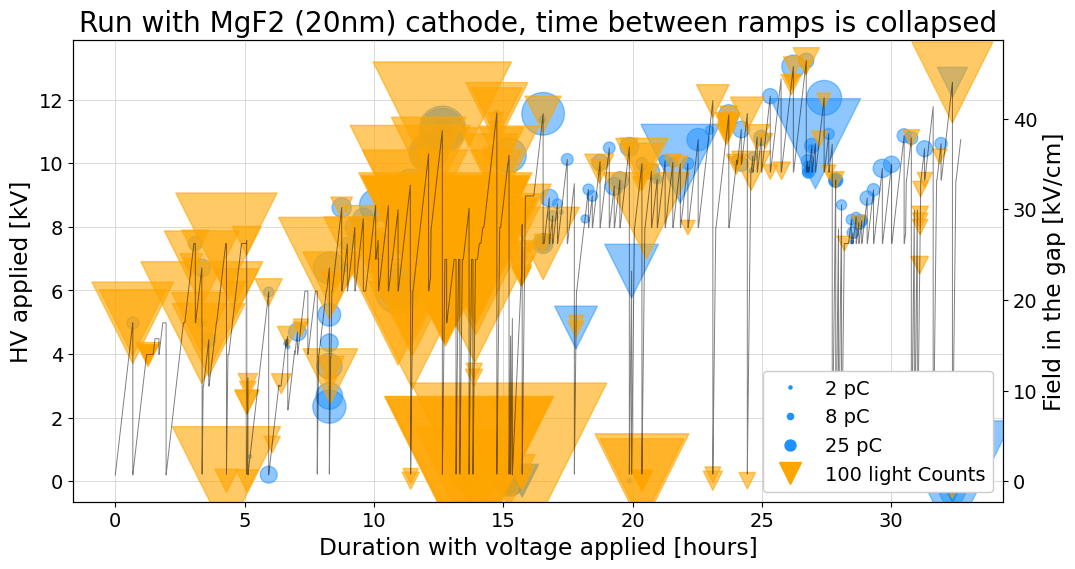

In [35]:
charge_dot_scale = 10
light_dot_scale = 10

# Define custom legend entries with markers
legend_elements = [\
    Line2D([0], [0], marker='o', linewidth=0, color='#1E90FF', markersize=np.sqrt(2*charge_dot_scale)/2, label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='#1E90FF', markersize=np.sqrt(8*charge_dot_scale)/2, label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='#1E90FF', markersize=np.sqrt(25*charge_dot_scale)/2, label='25 pC'),
    Line2D([0], [0], marker='v', linewidth=0, color='orange', markersize=np.sqrt(100*light_dot_scale)/2, label='100 light Counts')]

fig, ax = plt.subplots(figsize=(12,6))
    #ax.set_ylim([-1, 19]) #fixed axis for all
    #ax.set_xlim([-1, 42])
    
ana = anas[9]
d = ana.df
d = d[~d["ch3 charge"].isna()]
ana.load_hv_textfiles()
ana.correct_hv_data() #analyzes the ramp data to separate into a list of ramps and a list of flat tops
ana.create_time_duration_map()
ax.plot(np.array(ana.time_duration_map["dur"])/3600, ana.time_duration_map["v"], color='k', linewidth=0.7, alpha=0.5)

#negative polar events
mask = (d["ch3 n negpeaks"] > 0) & (d["ch3 n pospeaks"] == 0)# & (np.abs(d["ch3 charge"]) > 1)
d_ch = np.abs(np.array(d[mask]["ch3 charge"]))
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*charge_dot_scale), marker='o', alpha=0.5, facecolor='#1E90FF', edgecolor='#1E90FF')

#positive polar
mask = (d["ch3 n pospeaks"] > 1)# & (np.abs(d["ch3 charge"]) > 1)
d_ch = np.abs(np.array(d[mask]["ch3 charge"]))
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*charge_dot_scale), marker='v', alpha=0.5, facecolor='#1E90FF', edgecolor='#1E90FF')

# Add exceed_times points
exceed_durations = [ana.get_duration_from_timestamp(start) / 3600 for start, count in exceed_times]
exceed_counts = [count for start, count in exceed_times]
ax.scatter(exceed_durations, [ana.get_hv_at_time(start) for start, count in exceed_times], s=np.array(exceed_counts) * (light_dot_scale/2), marker='v', color='orange', alpha=0.6, label='PMT Count')

ax2 = ax.twinx()
E_f = lambda V:V/0.285
ymin, ymax = ax.get_ylim()
ax2.set_ylim(E_f(ymin), E_f(ymax))
ax2.plot([], [])
        
# Add legend with custom legend entries
ax.legend(handles=legend_elements, loc='lower right')
ax.set_ylabel("HV applied [kV]")
ax2.set_ylabel("Field in the gap [kV/cm]")
ax2.grid(False)
ax.set_xlabel("Duration with voltage applied [hours]")
ax.set_title("Run with {} cathode, time between ramps is collapsed".format(ana.title))
plt.show()